## Densenet 121

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with half size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0.001)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=256).normalize(imagenet_stats))

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [11]:
data

ImageDataBunch;

Train: LabelList (6246 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (6 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

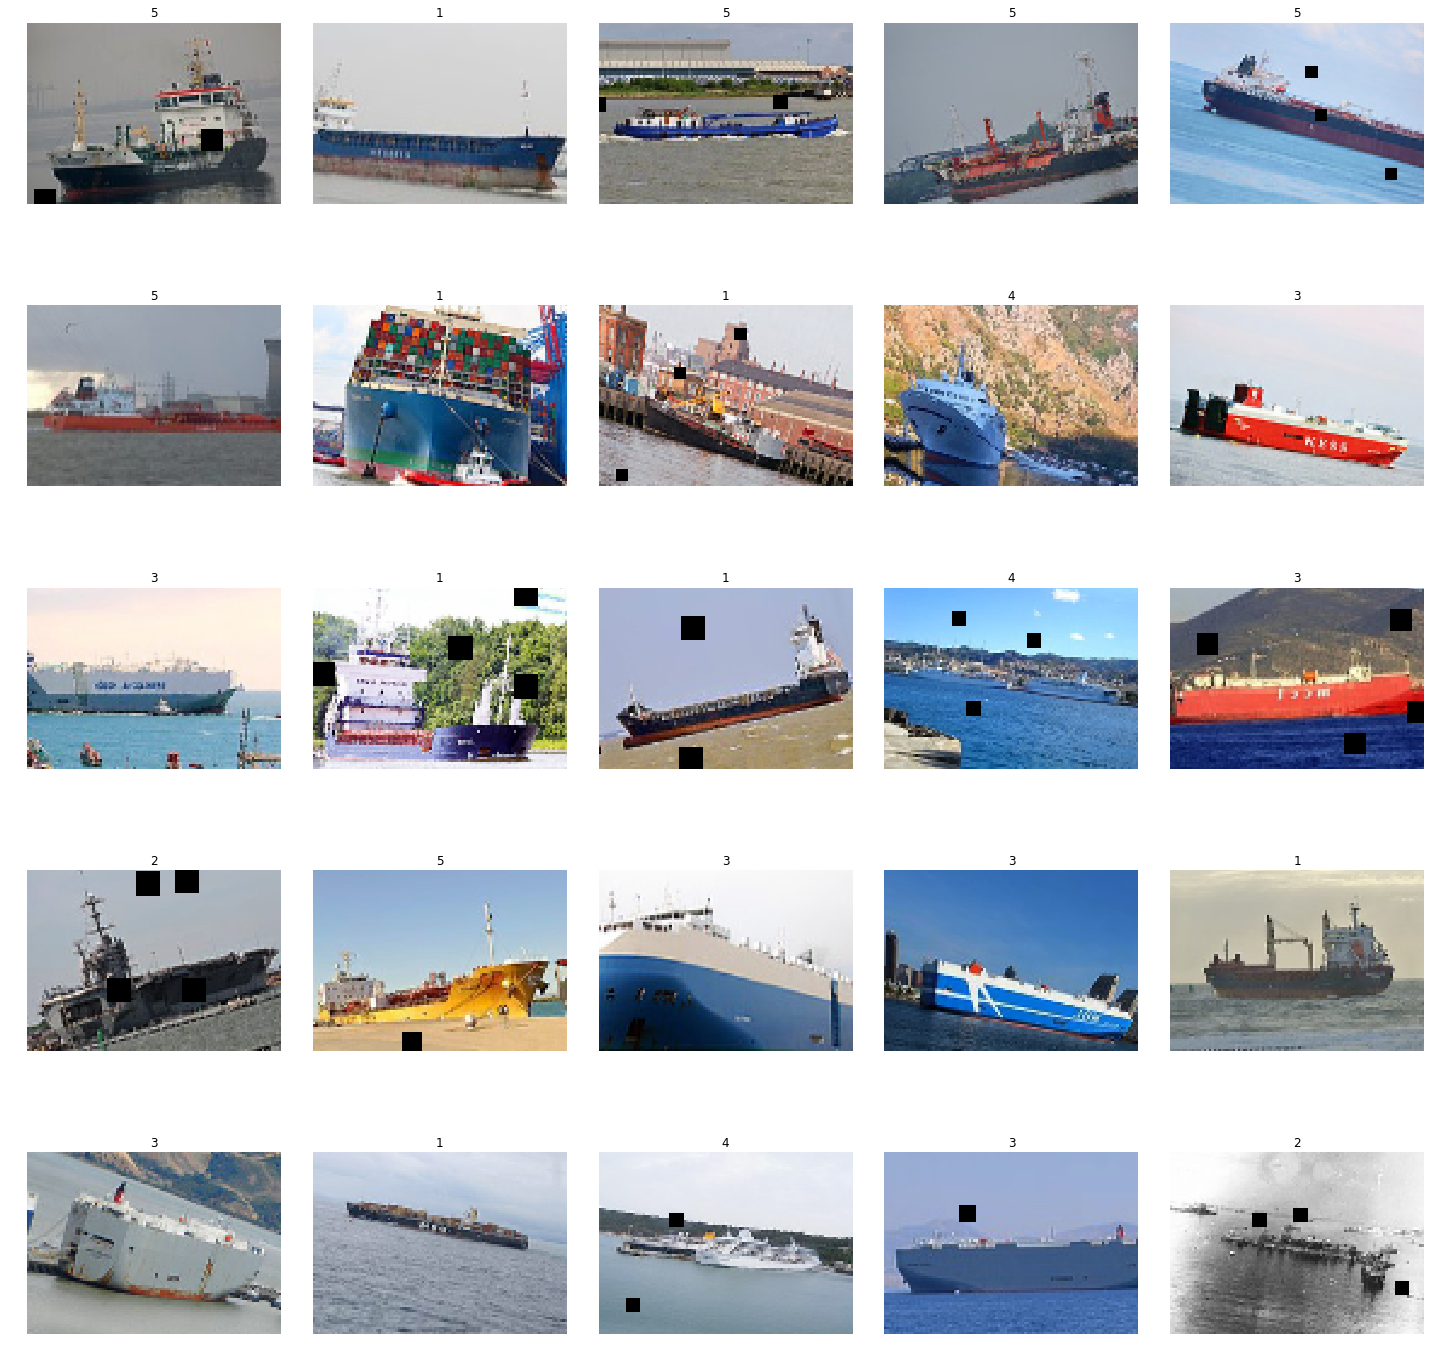

In [12]:
data.show_batch()

## Try with DenseNEt121

In [12]:
metrics_custom=[fbeta,accuracy_thresh]

In [13]:
learn=cnn_learner(data,models.densenet121,metrics=metrics_custom).load('dense121_best_stage-3-aug')

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


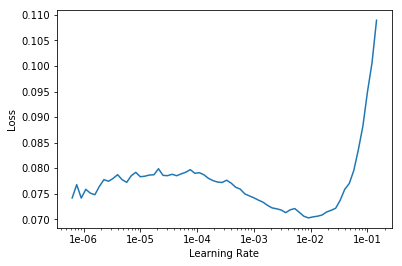

In [18]:
learn.recorder.plot()

In [14]:
lr=1e-3

In [15]:
learn.fit_one_cycle(8,slice(lr))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.075974,0.790480,0.500000,0.766667,00:07
1,0.072909,0.710642,0.638889,0.766667,00:06
2,0.066098,0.665178,0.638889,0.800000,00:05
3,0.064712,0.654574,0.638889,0.833333,00:05
4,0.060930,0.634374,0.638889,0.833333,00:05
5,0.056416,0.632544,0.638889,0.800000,00:06
6,0.056643,0.635994,0.638889,0.800000,00:05
7,0.054908,0.644044,0.638889,0.800000,00:05


In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


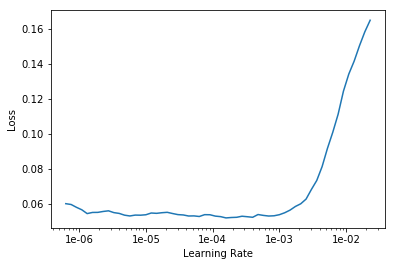

In [18]:
learn.recorder.plot()

In [40]:
#learn.load('dense121_best_stage-1-aug')

In [19]:
lr=1e-4

In [20]:
learn.fit_one_cycle(5,slice(lr,3e-2))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.070590,0.426975,0.777778,0.866667,00:06
1,0.094245,0.303586,0.805556,0.966667,00:06
2,0.093728,0.538938,0.638889,0.866667,00:06
3,0.082657,0.515573,0.666667,0.866667,00:06
4,0.069235,0.517825,0.638889,0.866667,00:06


## Pass full size image

In [21]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=64).normalize(imagenet_stats))

In [22]:
learn.freeze()

In [23]:
learn.data=data

In [24]:
learn.data

ImageDataBunch;

Train: LabelList (6246 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (6 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [31]:
learn.save('densenet121-stage-2-half-noval')

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


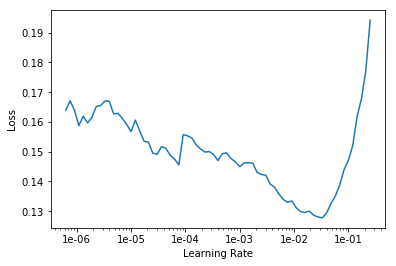

In [26]:
learn.recorder.plot()

In [27]:
lr=3e-3

In [28]:
learn.fit_one_cycle(8,slice(lr),wd=1e-5)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.120723,0.652678,0.500000,0.800000,00:14
1,0.088913,0.598659,0.500000,0.833333,00:14
2,0.076630,0.636386,0.500000,0.800000,00:14
3,0.061953,0.738772,0.500000,0.800000,00:14
4,0.060870,0.755142,0.500000,0.800000,00:14
5,0.055179,0.837976,0.500000,0.800000,00:14
6,0.049286,0.881153,0.500000,0.800000,00:14
7,0.049087,0.919739,0.500000,0.800000,00:14


In [29]:
learn.save('dense121_noval_stage-3-aug-freeze_full')

In [30]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [31]:
test_pred_tta

(tensor([[9.9818e-01, 1.0839e-04, 4.6348e-05, 1.3383e-03, 2.3014e-05],
         [8.1084e-04, 6.7997e-03, 9.7970e-01, 1.3159e-03, 2.7513e-03],
         [5.9542e-01, 1.5169e-01, 1.4052e-02, 1.3451e-01, 1.1194e-01],
         ...,
         [3.1777e-02, 5.1960e-03, 8.3402e-01, 4.2575e-02, 9.0682e-02],
         [7.9435e-04, 9.9943e-01, 7.2273e-05, 1.6956e-04, 1.5720e-04],
         [9.0256e-01, 4.3215e-04, 1.8938e-03, 3.8198e-03, 9.3966e-02]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [32]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 0,  ..., 2, 1, 0])

In [33]:
a=array(preds)

In [34]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [35]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,1
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [36]:
len(submission)

2680

In [37]:
submission.to_csv(PATH/'submission_densenet121-noval.csv',index=False)